<a href="https://colab.research.google.com/github/RohanMathur17/Knowledge_Distillation_Implementation/blob/main/Knowledge_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Knowledge Distillation 

It is an optimizational technique, used for model compression. It the process of transferring knowledge from a large model to a smaller one, without loss of validity and performance.

Why smaller? -> Obvious reasons

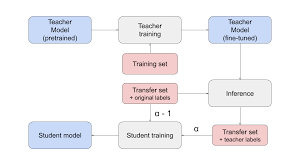


Approach -

1. Assume a teacher model assigns a larger variable for a class that is predicted right ( for a classification task).
Eg. if 3 is predicted among 1,2,3.
then predictions -> [0, 0, 1.0]

2. For a classification task, we use softmax. The logits are softened by applying a "temperature" scaling function in the softmax, effectively smoothing out the probability distribution and revealing inter-class relationships learned by the teacher ( psuedo probabilities).

3. Using this, the knowledge is transferred from a teacher model to the student by minimizing a loss function. For the student model, the ground truth labels would be the output of the teacher model.

For a student model, we use a higher temperature function.





Let us implement

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

### Example fo the meaning of temperature to soften the softmax output labels

In [2]:
logits= np.array([0,1,0,0,0])
T=[1,5,7,10]  # Setting temperature targets 
for t in T:
    logits_exp_norm= np.exp(logits)/sum(np.exp(logits))
    logits_exp_norm_with_T= np.exp(logits/t)/sum(np.exp(logits/t))  # Performing softmax and dividing it by T
    print("with T=",t, logits_exp_norm_with_T)
print("softmax :", logits_exp_norm)

with T= 1 [0.14884758 0.40460968 0.14884758 0.14884758 0.14884758]
with T= 5 [0.19151941 0.23392234 0.19151941 0.19151941 0.19151941]
with T= 7 [0.19404044 0.22383825 0.19404044 0.19404044 0.19404044]
with T= 10 [0.19587983 0.21648069 0.19587983 0.19587983 0.19587983]
softmax : [0.14884758 0.40460968 0.14884758 0.14884758 0.14884758]


As noticed, with only softmax and T=1 , the answers are the same. 

As T is increased the hard labels' ( 2nd index) probabilities are being spread out among other labels.

Why use Soft Targets?

1. They contain valuable information on the rich similarity structure over the data. ( Eg. if 1 looks like 7, the mdoel would probably recognize it).

2. Provide a better generalization and less variance. and also prevent overfitting.

3. Allows smaller Student model to be trained on much smaller data than original Teacher model with a much higher learning rate.

Why Knowledge Distillation?

1. Inherits better quality from teacher and is more efficient and samller.
2. Improves generalization. The teacher produces "soft targets" for training student model. Soft targets have high entropy providing more information than one hot encoded hard target. Soft targets prevent overfitting.

## Dataset Used

Dataset being used here is a simple Chess Piece Dataset. (https://www.kaggle.com/anshulmehtakaggl/chess-pieces-detection-images-dataset)

It has 5 classes with around 80-200 images in each class

In [3]:
!unrar x "/content/chess.rar" "/content/chess/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/chess.rar

Creating    /content/chess                                            OK
Creating    /content/chess/chess                                      OK
Creating    /content/chess/chess/bishop_resized                       OK
Extracting  /content/chess/chess/bishop_resized/00000000_resized.jpg       0%  OK 
Extracting  /content/chess/chess/bishop_resized/00000002_resized.jpg       0%  OK 
Extracting  /content/chess/chess/bishop_resized/00000003_resized.jpg       0%  OK 
Extracting  /content/chess/chess/bishop_resized/00000004_resized.jpg       0%  OK 
Extracting  /content/chess/chess/bishop_resized/00000005_resized.jpg       0%  OK 
Extracting  /content/chess/chess/bishop_resized/00000006_resized.jpg       0%  OK 
Extracting  /content/chess/chess/bishop_resized/00000008_resized.jpg       0%  OK 
Extracting  /content/chess/chess

In [4]:
## Implementing on Chess Kaggle Dataset

import os
from sklearn.model_selection import train_test_split
import cv2

X = []
y = []
base_dir = '/content/chess/chess/'
for f in sorted(os.listdir(base_dir)):
    if os.path.isdir(base_dir+f):
       # print(f"{f} is a target class")
        for i in sorted(os.listdir(base_dir+f)):
           # print(f"{i} is an input image path")
            X.append(base_dir+f+'/'+i)
            y.append(f)

(trainX, testX, trainY, testY) = train_test_split(X,y,
	test_size=0.25,random_state=42)

trainX_list = []
for imagePath in trainX:
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    trainX_list.append(image)

testX_list = []
for imagePath in testX:
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    testX_list.append(image)

trainY_array = np.unique(trainY, return_inverse=True)[1]
trainY_array = trainY_array.reshape(len(trainY_array),1)

testY_array = np.unique(testY, return_inverse=True)[1]
testY_array = testY_array.reshape(len(testY_array),1)

trainX_list_array = np.asarray(trainX_list)
testX_list_array  = np.asarray(testX_list)


In [5]:
# Normalize data
trainX_list_array = trainX_list_array.astype("float32") / 255.0
trainX_list_array = np.reshape(trainX_list_array, (-1, 224, 224, 3))

testX_list_array = testX_list_array.astype("float32") / 255.0
testX_list_array = np.reshape(testX_list_array, (-1, 224, 224, 3))

# Print shapes
print(trainY_array.shape)
print(trainX_list_array.shape)

print(testY_array.shape)
print(testX_list_array.shape)

(488, 1)
(488, 224, 224, 3)
(163, 1)
(163, 224, 224, 3)


Create the teacher model 

In [6]:
teacher = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(224, 224, 3)),
        
        tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(5), # For 10 predictions
    ],
    name="teacher",
)
teacher.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 256)     7168      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 256)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 256)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 512)       1180160   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 56, 56, 512)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 512)      0         
 2D)                                                       

Create student model

In [7]:
# Create the student

# Has smaller convolutions than the teacher model

student = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(224, 224, 3)),
        tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(5),
    ],
    name="student",
)
student.summary()

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      1792      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       147712    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 56, 56, 256)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 256)      0         
 2D)                                                       

 As noticed, Teacher model has higher parameters than the student model.

In [8]:
teacher.compile(
    optimizer=tf.keras.optimizers.Adam(),    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


# Train and evaluate teacher on data.
teacher.fit(trainX_list_array, trainY_array, epochs=10)
teacher.evaluate(testX_list_array, testY_array)

Epoch 1/10
16/16 [==============================] - 16s 306ms/step - loss: 21.8781 - sparse_categorical_accuracy: 0.2049
Epoch 2/10
16/16 [==============================] - 4s 260ms/step - loss: 4.3212 - sparse_categorical_accuracy: 0.2275
Epoch 3/10
16/16 [==============================] - 4s 260ms/step - loss: 3.6734 - sparse_categorical_accuracy: 0.3176
Epoch 4/10
16/16 [==============================] - 4s 264ms/step - loss: 1.4400 - sparse_categorical_accuracy: 0.4775
Epoch 5/10
16/16 [==============================] - 4s 262ms/step - loss: 1.3116 - sparse_categorical_accuracy: 0.5307
Epoch 6/10
16/16 [==============================] - 4s 263ms/step - loss: 0.9676 - sparse_categorical_accuracy: 0.6189
Epoch 7/10
16/16 [==============================] - 4s 265ms/step - loss: 0.8358 - sparse_categorical_accuracy: 0.6783
Epoch 8/10
16/16 [==============================] - 4s 265ms/step - loss: 0.6129 - sparse_categorical_accuracy: 0.8094
Epoch 9/10
16/16 [============================

[2.346895933151245, 0.4110429584980011]

## Distill Knowledge from Teacher Model to Student Model

Now we will create a distiller class to distill the knowledge using the student and distillation.

Some Key Points:
1. Student Loss Function -> Difference b/w student predictions and ground truth ( where T = 1 for softmax).
2. Distillation Loss Function -> Difference b.w soft student predictions and soft teacher labels.

In [9]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher  # Teacher model
        self.student = student  # Student Model

    def compile( # Initialize all metrics
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data # Data and labels

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False) # Find teacher predictions
        print("Teacher prediction: ", teacher_predictions)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1), # Add T > 1
                tf.nn.softmax(student_predictions / self.temperature, axis=1), # Add T > 1
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss  # Overall loss
            print("Loss in distiller: ",loss)

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        print("Train:  ", results)
        return results

    def test_step(self, data): #Prediction on the student and calculating loss
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        print(" Test: ", results)
        return results


In [10]:
# Initialize  distiller
distiller= Distiller(student=student, teacher=teacher)

#compile distiller
distiller.compile(optimizer=keras.optimizers.Adam(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()],
                 student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 distillation_loss_fn=keras.losses.KLDivergence(),
                 alpha=0.3,
                 temperature=7)


Distill the knowledge from the Teacher model to Student and Evaluate the distiller

In [11]:
# Distill teacher to student
distiller.fit(trainX_list_array, trainY_array, epochs=10)
# Evaluate student on test dataset
distiller.evaluate(testX_list_array, testY_array)

Epoch 1/10
Teacher prediction:  Tensor("teacher/dense/BiasAdd:0", shape=(None, 5), dtype=float32)
Loss in distiller:  Tensor("add:0", shape=(), dtype=float32)
Train:   {'sparse_categorical_accuracy': <tf.Tensor 'Identity:0' shape=() dtype=float32>, 'student_loss': <tf.Tensor 'sparse_categorical_crossentropy/weighted_loss/value:0' shape=() dtype=float32>, 'distillation_loss': <tf.Tensor 'kl_divergence/weighted_loss/value:0' shape=() dtype=float32>}
Teacher prediction:  Tensor("teacher/dense/BiasAdd:0", shape=(None, 5), dtype=float32)
Loss in distiller:  Tensor("add:0", shape=(), dtype=float32)
Train:   {'sparse_categorical_accuracy': <tf.Tensor 'Identity:0' shape=() dtype=float32>, 'student_loss': <tf.Tensor 'sparse_categorical_crossentropy/weighted_loss/value:0' shape=() dtype=float32>, 'distillation_loss': <tf.Tensor 'kl_divergence/weighted_loss/value:0' shape=() dtype=float32>}
16/16 [==============================] - 3s 150ms/step - sparse_categorical_accuracy: 0.2213 - student_loss

[0.47852760553359985, 0.7264487743377686]

Now we have the results for our distilled model.

Let us train the student model from scratch to see how that compares with the Teacher and Distilled Model

In [12]:
student.compile(
    optimizer=tf.keras.optimizers.Adam(),    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# Train and evaluate teacher on data.
student.fit(trainX_list_array, trainY_array, epochs=10)
student.evaluate(testX_list_array, testY_array)

Epoch 1/10
16/16 [==============================] - 1s 60ms/step - loss: 1.3627 - sparse_categorical_accuracy: 0.6906
Epoch 2/10
16/16 [==============================] - 1s 57ms/step - loss: 0.4448 - sparse_categorical_accuracy: 0.8463
Epoch 3/10
16/16 [==============================] - 1s 58ms/step - loss: 0.2739 - sparse_categorical_accuracy: 0.9160
Epoch 4/10
16/16 [==============================] - 1s 56ms/step - loss: 0.2352 - sparse_categorical_accuracy: 0.9262
Epoch 5/10
16/16 [==============================] - 1s 56ms/step - loss: 0.1560 - sparse_categorical_accuracy: 0.9611
Epoch 6/10
16/16 [==============================] - 1s 57ms/step - loss: 0.1290 - sparse_categorical_accuracy: 0.9693
Epoch 7/10
16/16 [==============================] - 1s 57ms/step - loss: 0.1067 - sparse_categorical_accuracy: 0.9631
Epoch 8/10
16/16 [==============================] - 1s 57ms/step - loss: 0.0825 - sparse_categorical_accuracy: 0.9775
Epoch 9/10
16/16 [==============================] - 1s 5

[3.247504234313965, 0.5153374075889587]

Let Us Observe the results:

For Teacher Model ->

1. Loss -> 2.346895933151245
2. Accuracy -> 0.4110429584980011

For Student Model ->

1. Loss -> 3.247504234313965
2. Accuracy -> 0.5153374075889587


For Student Model after Distillation ->

1. Loss -> 0.47852760553359985 
2. Accuracy -> 0.7264487743377686



As seen there is a huge jump in the accuracy for the distilled model.
Also, distiller takes less time to train than a teacher model.



Conclusion:
Knowledge distillation is a model agnostic compression technique that extracts the knowledge from the large cumbersome Teacher model and passes it on to the smaller Student model. The Knowledge distillation model uses soft targets and has less training and inference time but a higher accuracy than the large cumbersome Teacher Model.

References.

1. https://keras.io/examples/vision/knowledge_distillation/

2. https://medium.com/analytics-vidhya/knowledge-distillation-in-a-deep-neural-network-c9dd59aff89b